## 1. Importing Libraries and reading data 

In [18]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.feature_selection import SelectKBest, f_classif
import joblib

In [3]:
# Read the dataset into a data frame
df = pd.read_csv(r'C:\Users\abanoup\Downloads\Diabetes_preprocessed.csv')


## 2. Preprocessing Data

In [4]:
# We will be dropping the clinical notes and since most people's smoking history is not known we will drop that too
df = df.drop(['clinical_notes','smoking_history'], axis=1)

In [5]:
df.columns

Index(['year', 'gender', 'age', 'location', 'race:AfricanAmerican',
       'race:Asian', 'race:Caucasian', 'race:Hispanic', 'race:Other',
       'hypertension', 'heart_disease', 'bmi', 'hbA1c_level',
       'blood_glucose_level', 'diabetes'],
      dtype='object')

In [6]:
# Dealing with categorical variables 
df = pd.get_dummies(df,columns=['gender'])  # Encoding the gender column 

#For location we will do frequency encoding
location_freq = df['location'].value_counts(normalize=True)
df['loc_freq'] = df['location'].map(location_freq)
df.drop(['location'],axis=1, inplace=True)

In [7]:
df.head()

,year,age,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,bmi,hbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,loc_freq
0,2020,32.0,0,0,0,0,1,0,0,27.32,5.0,100,0,1,0,0,0.02099
1,2015,29.0,0,1,0,0,0,0,0,19.95,5.0,90,0,1,0,0,0.02099
2,2015,18.0,0,0,0,0,1,0,0,23.76,4.8,160,0,0,1,0,0.02099
3,2015,41.0,0,0,1,0,0,0,0,27.32,4.0,159,0,0,1,0,0.02099
4,2016,52.0,1,0,0,0,0,0,0,23.75,6.5,90,0,1,0,0,0.02099


In [8]:
df.columns

Index(['year', 'age', 'race:AfricanAmerican', 'race:Asian', 'race:Caucasian',
       'race:Hispanic', 'race:Other', 'hypertension', 'heart_disease', 'bmi',
       'hbA1c_level', 'blood_glucose_level', 'diabetes', 'gender_Female',
       'gender_Male', 'gender_Other', 'loc_freq'],
      dtype='object')

In [9]:
# Dealing with numerical columns 
scaler = StandardScaler()
num_col = ['year', 'age','bmi','hbA1c_level','blood_glucose_level']
df[num_col] = scaler.fit_transform(df[num_col])
df.head()

,year,age,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,bmi,hbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,loc_freq
0,1.218003,-0.438416,0,0,0,0,1,0,0,0.000044,-0.493079,-0.934414,0,1,0,0,0.02099
1,-2.545921,-0.571707,0,1,0,0,0,0,0,-1.110113,-0.493079,-1.179935,0,1,0,0,0.02099
2,-2.545921,-1.060442,0,0,0,0,1,0,0,-0.536205,-0.679877,0.538712,0,0,1,0,0.02099
3,-2.545921,-0.038542,0,0,1,0,0,0,0,0.000044,-1.427069,0.514160,0,0,1,0,0.02099
4,-1.793136,0.450193,1,0,0,0,0,0,0,-0.537712,0.907905,-1.179935,0,1,0,0,0.02099


## 3. Feature Engineering 

We will here create another dataset and do some feature engineering to see if adding certain features contributes towards a better prediction 

In [10]:
#1. Age BMI interaction 
df['age_bmi'] = df['age'] * df['bmi']
df['comorbidity_count'] = df['hypertension'] + df['heart_disease']

## 4. Using different ML Algorithms

In [11]:
from imblearn.under_sampling import RandomUnderSampler

In [12]:
# Define features and target
X = df.drop('diabetes', axis=1)  
y = df['diabetes']

In [13]:
selector = SelectKBest(score_func=f_classif, k=10)  # Select top 10 features
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()
print("Selected features:", selected_features)

Selected features: ['age', 'hypertension', 'heart_disease', 'bmi', 'hbA1c_level', 'blood_glucose_level', 'gender_Female', 'gender_Male', 'age_bmi', 'comorbidity_count']


In [14]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

C:\Users\abanoup\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [16]:
# Print class distribution
print("Before SMOTE:", Counter(y))
print("After SMOTE:", Counter(y_resampled))

Before SMOTE: Counter({0: 88760, 1: 8239})
After SMOTE: Counter({0: 88760, 1: 88760})



LogisticRegression:

              precision    recall  f1-score   support

           0       0.88      0.89      0.89     17701
           1       0.89      0.88      0.89     17803

    accuracy                           0.89     35504
   macro avg       0.89      0.89      0.89     35504
weighted avg       0.89      0.89      0.89     35504

AUC: 0.9626075390010227


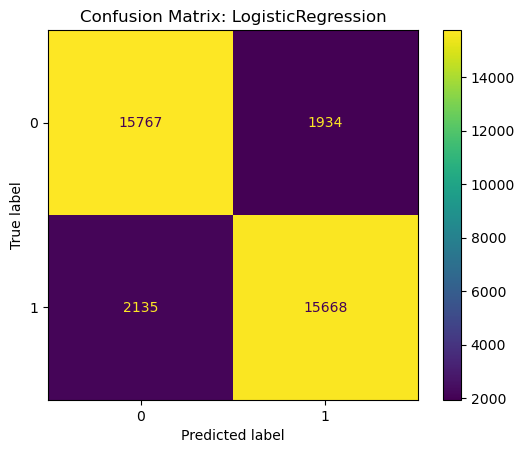


RandomForest:

              precision    recall  f1-score   support

           0       0.93      0.92      0.92     17701
           1       0.92      0.93      0.92     17803

    accuracy                           0.92     35504
   macro avg       0.92      0.92      0.92     35504
weighted avg       0.92      0.92      0.92     35504

AUC: 0.9830144427314385


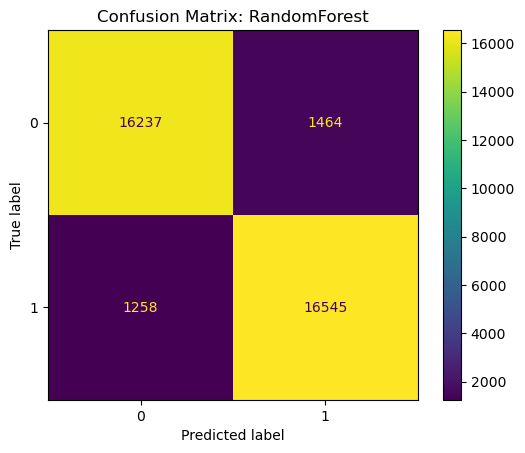


GradientBoosting:

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     17701
           1       0.96      0.94      0.95     17803

    accuracy                           0.95     35504
   macro avg       0.95      0.95      0.95     35504
weighted avg       0.95      0.95      0.95     35504

AUC: 0.9933074859370424


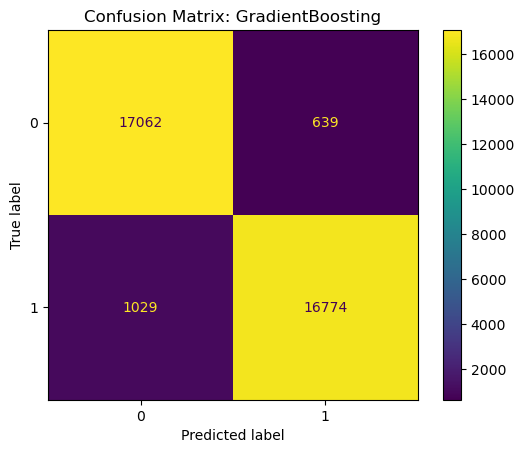


K-NearestNeighbors:

              precision    recall  f1-score   support

           0       0.98      0.92      0.95     17701
           1       0.92      0.98      0.95     17803

    accuracy                           0.95     35504
   macro avg       0.95      0.95      0.95     35504
weighted avg       0.95      0.95      0.95     35504

AUC: 0.9834064782278747


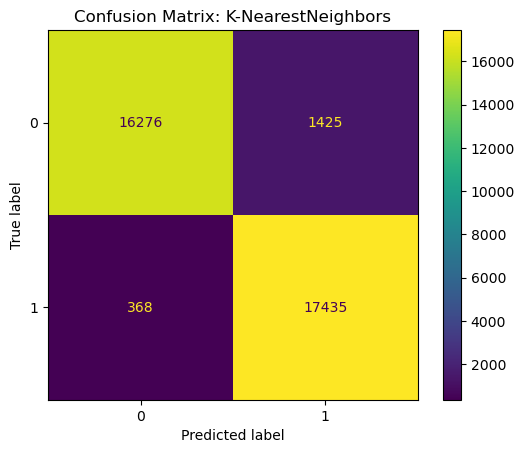


XGBoost:

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     17701
           1       0.96      0.95      0.95     17803

    accuracy                           0.95     35504
   macro avg       0.95      0.95      0.95     35504
weighted avg       0.95      0.95      0.95     35504

AUC: 0.9935710399052803


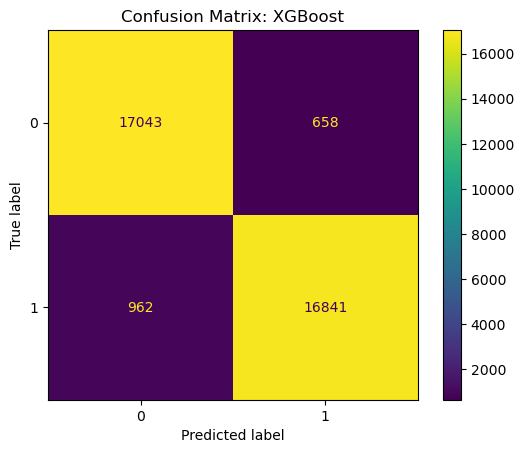

Best parameters for RandomForest: {'max_depth': 10, 'n_estimators': 100}
Best AUC score: 0.9827721592324709


In [17]:
# Define models
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, C=0.1),
    "RandomForest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "K-NearestNeighbors": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, eval_metric='logloss', random_state=42)
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"\n{name}:\n")
    print(classification_report(y_test, y_pred))
    
    if hasattr(model, 'predict_proba'):
        y_probs = model.predict_proba(X_test)[:, 1]
        print("AUC:", roc_auc_score(y_test, y_probs))
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots()
    disp.plot(ax=ax)
    ax.set_title(f"Confusion Matrix: {name}")
    plt.show()

# Hyperparameter tuning for RandomForest
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print("Best parameters for RandomForest:", grid_search.best_params_)
print("Best AUC score:", grid_search.best_score_)

# Save The Model 


In [21]:
# Save the best RandomForest model to a .pkl file
best_rf_model = grid_search.best_estimator_
joblib.dump(best_rf_model, 'Diabetes_model.pkl')
print("RandomForest model saved as 'Diabetes_model.pkl'")

RandomForest model saved as 'Diabetes_model.pkl'


In [22]:
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(selector, 'selector.pkl')

['selector.pkl']